# Unidirection communication

- 1 speaker
- 1 listener

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings

warnings.filterwarnings('ignore')

You can skip training and instead load the last trained policy by changing the flag below.

In [3]:
from navground.learning.utils.jupyter import skip_if, run_if

training = True

In [4]:
from navground.learning import DefaultObservationConfig, DefaultStateConfig, ControlActionConfig
from navground.learning.config.control_action_with_comm import ControlActionWithCommConfig
from navground.learning.examples.pad import comm, marker, PadReward, is_success, is_failure
from navground.learning.scenarios.pad import render_kwargs, PadScenario
from navground.learning.parallel_env import parallel_env
from navground.learning import GroupConfig

name = "DirectionalComm"
comm_size = 1
action_speaker = ControlActionWithCommConfig(use_acceleration_action=True, max_acceleration=1, 
                                             fix_orientation=True, comm_size=comm_size)
action_listener = ControlActionConfig(use_acceleration_action=True, max_acceleration=1, 
                                      fix_orientation=True)
observation = DefaultObservationConfig(flat=False, include_velocity=True, include_target_direction=False)
state = DefaultStateConfig(include_y=False, include_position=True, include_velocity=True)
reward = PadReward(neighbor_weight=0.5)
speaker = GroupConfig(indices=[0], action=action_speaker, observation=observation, 
                      sensors=[marker()], tag='speaker', reward=reward,
                      terminate_on_success=True, terminate_on_failure=False,
                      success_condition=is_success, failure_condition=is_failure)
listener = GroupConfig(indices=[1], action=action_listener, observation=observation, 
                       sensors=[comm(size=comm_size), marker()], tag='listener', reward=reward,
                       terminate_on_success=True, terminate_on_failure=False,
                       success_condition=is_success, failure_condition=is_failure)
groups = [speaker, listener]
train_scenario = PadScenario(start_in_opposite_sides=False)
test_scenario = PadScenario(start_in_opposite_sides=True)
train_env = parallel_env(groups=groups, state=state, scenario=train_scenario, 
                         include_success=False, wait=True, max_duration=20, time_step=0.1)
rkwargs = render_kwargs(comm=True, low=-1, color_low=(1, 0, 0), color_high=(0, 1, 0))
test_env = parallel_env(groups=groups, state=state, scenario=test_scenario,
                        include_success=True, init_success=False, intermediate_success=True, 
                        render_mode='rgb_array', render_kwargs=rkwargs, wait=True,
                        max_duration=20, time_step=0.1)

In [5]:
%%skip_if $training

import pathlib, os
from navground.learning.utils.benchmarl import NavgroundExperiment

path = max(pathlib.Path(f'logs/{name}/MASAC').glob('*/checkpoints/*.pt'), key=os.path.getmtime)
experiment = NavgroundExperiment.reload_from_file(str(path))
experiment.folder_name

In [6]:
%%run_if $training

import os
from benchmarl.algorithms import MasacConfig
from benchmarl.models.mlp import MlpConfig
from benchmarl.experiment import ExperimentConfig
from navground.learning.utils.benchmarl import NavgroundExperiment, ExportPolicyCallback

algorithm = MasacConfig.get_from_yaml()
model = MlpConfig.get_from_yaml()
config = ExperimentConfig.get_from_yaml()
config.loggers = [ 'csv']
config.render = True
config.evaluation_interval = 6000
config.evaluation_episodes = 30
config.lr = 3e-4
config.max_n_iters = 1
config.checkpoint_at_end = True
config.save_folder = f'logs/{name}/MASAC'
os.makedirs(config.save_folder, exist_ok=True)
experiment_masac = NavgroundExperiment(
    env=train_env,
    eval_env=test_env,
    config=config,
    model_config=model,
    critic_model_config=model,
    algorithm_config=algorithm,
    seed=0,
    callbacks=[ExportPolicyCallback()]
)
experiment_masac.folder_name

PosixPath('logs/DirectionalComm/MASAC/masac_navground_mlp__f924c091_25_05_21-16_28_14')

In [7]:
experiment_masac.observation_space('speaker'), experiment_masac.action_space('speaker')

(Dict('pad/x': Box(-1.0, 1.0, (1,), float32), 'ego_velocity': Box(-0.14, 0.14, (1,), float32)),
 Box(-1.0, 1.0, (2,), float32))

In [8]:
experiment_masac.observation_space('listener'), experiment_masac.action_space('listener')

(Dict('neighbor/comm': Box(-1.0, 1.0, (1,), float32), 'pad/x': Box(-1.0, 1.0, (1,), float32), 'ego_velocity': Box(-0.14, 0.14, (1,), float32)),
 Box(-1.0, 1.0, (1,), float32))

In [ ]:
%%run_if $training

experiment_masac.run_for(iterations=100)

mean return = -37.342201232910156:  34%|███████████████████████████████████████████████▉                                                                                             | 34/100 [22:28<44:20, 40.31s/it]

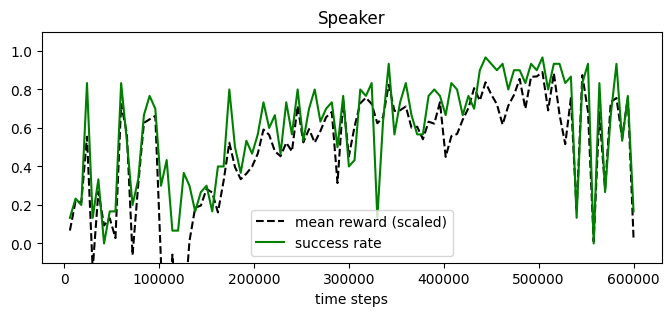

In [13]:
experiment_masac.plot_eval_logs(group='speaker', reward_low=-200, reward_high=0, 
                                success=True, figsize=(8, 3), title="Speaker")
                                    

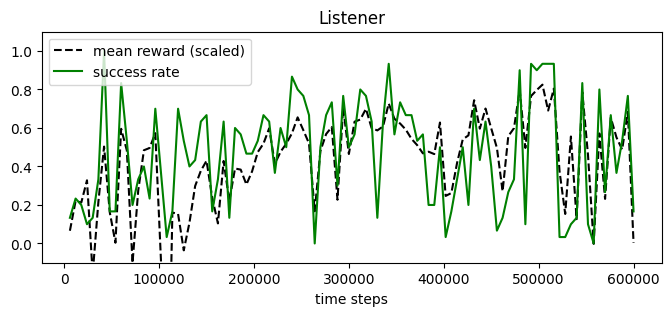

In [14]:
experiment_masac.plot_eval_logs(group='listener', reward_low=-200, reward_high=0, 
                                success=True, figsize=(8, 3), title="Listener")

In [15]:
from navground.learning.evaluation.video import display_episode_video

groups = experiment_masac.get_single_agent_policies()
display_episode_video(test_env, groups=groups, factor=4, select=20, of=31, **rkwargs)

In [16]:
groups = experiment_masac.load_policies(name="best_policy")
display_episode_video(test_env, groups=groups, factor=4, select=15, of=31, **rkwargs)

Text(0.5, 1.0, 'Speaker')

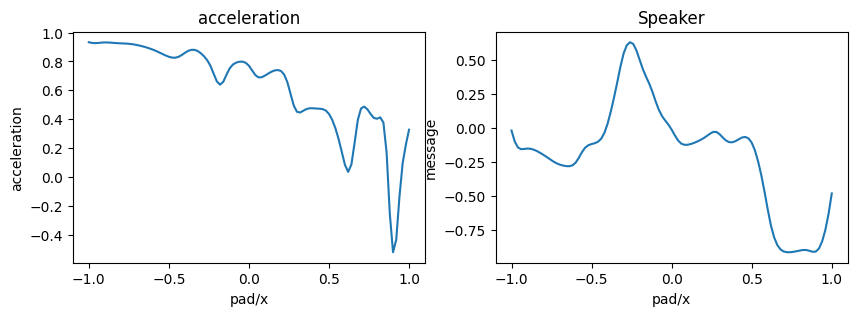

In [19]:
from navground.learning.utils.plot import plot_policy
from matplotlib import pyplot as plt

plot_policy(groups[0].policy, 
            variable={'pad/x': (-1, 1)},
            fix={'ego_velocity': 0.1},
            actions={0: 'acceleration', 1: 'message'}, 
            width=5, height=3)
plt.title("Speaker")

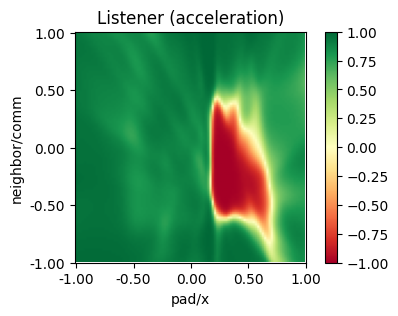

In [23]:
plot_policy(groups[1].policy, 
            variable={'pad/x': (-1, 1), 'neighbor/comm': (-1, 1)},
            fix={'ego_velocity': 0.1},
            actions={0: 'acceleration'}, 
            width=5, height=3)
plt.title("Listener (acceleration)");

In [24]:
from navground.learning.evaluation.video import record_episode_video

record_episode_video(test_env, path=f'../videos/{name}.mp4', groups=groups, factor=4, 
                     select=15, of=31, **rkwargs)